In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
# IO-related
import os.path as osp

import imageio

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# image processing
import numpy as np

# visualization
import plotly.graph_objects as go
import scipy.ndimage as ndi
import scipy.signal as scs
import seaborn as sns
import skimage as ski
import skimage.measure as skmeas
import skimage.morphology as skm
from PIL import Image

import time
import math

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
# Model Hyperparameters
dataset_path = '~/datasets'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 100
x_dim  = 784
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 30

In [ ]:
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

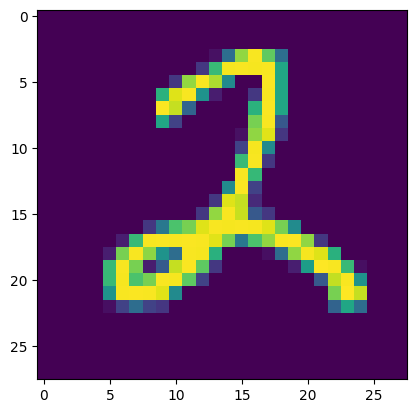

In [6]:
plt.imshow((next(iter(train_loader))[0][10].permute(1, 2, 0)))

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self._input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
        )
        self._fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self._fc_var   = nn.Linear (hidden_dim, latent_dim)

    def forward(self, x):
        output_  = self._input(x)
        mean_    = self._fc_mean(output_)
        log_var_ = self._fc_var(output_)
        return mean_, log_var_

In [24]:
enc = Encoder(10, 12, 4)
x = np.random.normal(1, size=10)
t = torch.tensor(x, dtype=torch.float32).reshape(1, 10)
out = enc(t)[0]
print(out)

tensor([[-0.2733, -0.0937,  0.1184, -0.2805]], grad_fn=<AddmmBackward0>)


In [25]:
print(enc, enc._input[0].weight)

Encoder(
  (_input): Sequential(
    (0): Linear(in_features=10, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (_fc_mean): Linear(in_features=12, out_features=4, bias=True)
  (_fc_var): Linear(in_features=12, out_features=4, bias=True)
) Parameter containing:
tensor([[-0.0753,  0.1565, -0.2414,  0.1153, -0.1910, -0.0810, -0.1041,  0.0998,
          0.2919, -0.1961],
        [-0.1276, -0.1568,  0.2295,  0.1153, -0.0871, -0.0728,  0.0167, -0.2921,
         -0.1026, -0.2784],
        [ 0.2158,  0.0407, -0.2592,  0.1622, -0.1092,  0.0423, -0.2182,  0.1141,
         -0.2379,  0.3117],
        [ 0.0903, -0.0175,  0.2558,  0.2922, -0.1295, -0.1853,  0.2907, -0.1324,
         -0.3147,  0.1657],
        [ 0.2522,  0.2798, -0.0980, -0.2025,  0.0845,  0.2508,  0.0015, -0.0615,
          0.1876,  0.2659],
        [ 0.1705,  0.3129,  0.2552,  0.0140, -0.2084, -0.2694, -0.081

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self._output = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        x_ = torch.sigmoid(self._output(x))
        return x_

In [9]:
class VAEModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAEModel, self).__init__()
        self._encoder = encoder
        self._decoder = decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)       # sampling epsilon
        z = mean + var * epsilon              # reparameterization trick
        return z

    def forward(self, x):
        mean_, log_var_ = self._encoder(x)
        z = self.reparameterization(mean_, torch.exp(0.5 * log_var_))
        x_ = self._decoder(z)
        return x_, mean_, log_var_

In [10]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

vae_model = VAEModel(encoder=encoder, decoder=decoder)
vae_model

VAEModel(
  (_encoder): Encoder(
    (_input): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=400, out_features=400, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (_fc_mean): Linear(in_features=400, out_features=200, bias=True)
    (_fc_var): Linear(in_features=400, out_features=200, bias=True)
  )
  (_decoder): Decoder(
    (_output): Sequential(
      (0): Linear(in_features=200, out_features=400, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=400, out_features=400, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=400, out_features=784, bias=True)
    )
  )
)

In [11]:
from torch.optim import Adam

bce_loss = nn.BCELoss()

def loss_function(x_in, x_out, mean, log_var):
    rep_loss = nn.functional.binary_cross_entropy(x_out, x_in, reduction='sum')
    kld      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return rep_loss + kld


In [12]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def train_epoch(dataloader, model, optimizer, criterion):

    total_loss = 0
    for batch_idx, (data, labels) in enumerate(tqdm(dataloader)):
        optimizer.zero_grad()
        inputs = data.view(batch_size, -1)

        outputs, mean, log_var = model(inputs)

        loss = criterion(inputs, outputs, mean, log_var)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

In [14]:
def train(train_dataloader, model, n_epochs, learning_rate=0.001, print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss_function
    model.train()

    for epoch in range(1, n_epochs + 1):
        print("Epoch", epoch)
        loss = train_epoch(train_dataloader, model, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Epoch 1


100%|██████████| 600/600 [00:26<00:00, 22.27it/s]


0m 26s (- 8m 32s) (1 5%) 17508.6109
Epoch 2


100%|██████████| 600/600 [00:27<00:00, 21.62it/s]


0m 54s (- 8m 12s) (2 10%) 12940.4847
Epoch 3


100%|██████████| 600/600 [00:26<00:00, 22.63it/s]


1m 21s (- 7m 40s) (3 15%) 11653.2069
Epoch 4


100%|██████████| 600/600 [00:26<00:00, 22.22it/s]


1m 48s (- 7m 13s) (4 20%) 11240.9642
Epoch 5


100%|██████████| 600/600 [00:25<00:00, 23.52it/s]


2m 13s (- 6m 41s) (5 25%) 10986.4530
Epoch 6


100%|██████████| 600/600 [00:26<00:00, 23.04it/s]


2m 39s (- 6m 12s) (6 30%) 10808.9177
Epoch 7


100%|██████████| 600/600 [00:26<00:00, 22.34it/s]


3m 6s (- 5m 46s) (7 35%) 10701.1980
Epoch 8


100%|██████████| 600/600 [00:27<00:00, 21.52it/s]


3m 34s (- 5m 21s) (8 40%) 10615.0929
Epoch 9


100%|██████████| 600/600 [00:26<00:00, 22.45it/s]


4m 1s (- 4m 54s) (9 45%) 10543.4430
Epoch 10


100%|██████████| 600/600 [00:30<00:00, 19.52it/s]


4m 32s (- 4m 32s) (10 50%) 10481.7350
Epoch 11


100%|██████████| 600/600 [00:26<00:00, 22.80it/s]


4m 58s (- 4m 4s) (11 55%) 10419.2210
Epoch 12


100%|██████████| 600/600 [00:25<00:00, 23.32it/s]


5m 24s (- 3m 36s) (12 60%) 10375.7188
Epoch 13


100%|██████████| 600/600 [00:26<00:00, 22.30it/s]


5m 51s (- 3m 9s) (13 65%) 10334.7230
Epoch 14


100%|██████████| 600/600 [00:27<00:00, 22.03it/s]


6m 18s (- 2m 42s) (14 70%) 10298.1306
Epoch 15


100%|██████████| 600/600 [00:27<00:00, 22.22it/s]


6m 45s (- 2m 15s) (15 75%) 10268.8142
Epoch 16


100%|██████████| 600/600 [00:26<00:00, 22.27it/s]


7m 12s (- 1m 48s) (16 80%) 10238.0480
Epoch 17


100%|██████████| 600/600 [00:26<00:00, 22.91it/s]


7m 38s (- 1m 20s) (17 85%) 10212.2673
Epoch 18


100%|██████████| 600/600 [00:26<00:00, 22.47it/s]


8m 5s (- 0m 53s) (18 90%) 10191.0975
Epoch 19


100%|██████████| 600/600 [00:27<00:00, 22.13it/s]


8m 32s (- 0m 26s) (19 95%) 10174.0953
Epoch 20


100%|██████████| 600/600 [00:27<00:00, 21.76it/s]


8m 59s (- 0m 0s) (20 100%) 10149.6401


<Figure size 640x480 with 0 Axes>

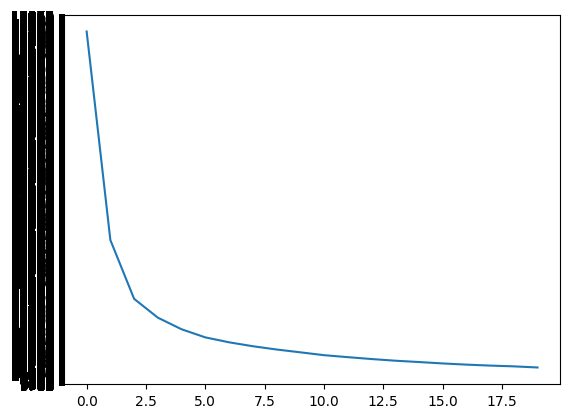

In [15]:
train(train_loader, vae_model, 20, print_every=1, plot_every=1)

In [16]:
for batch_idx, (data, labels) in enumerate(tqdm(test_loader)):
    print(data.shape)
    break

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 1, 28, 28])


In [18]:
%pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.6 MB/s eta 0:00:00


In [19]:
from torcheval.metrics import PeakSignalNoiseRatio

def evaluate(test_dataloader, model):
    images = []

    metric = PeakSignalNoiseRatio()
    model.eval()
    for batch_idx, (data, labels) in enumerate(tqdm(test_dataloader)):
        with torch.no_grad():
            inputs = data.view(batch_size, -1)
            outputs, _, _ = model(inputs)
            images.append((inputs.cpu().detach(), outputs.cpu().detach()))
            metric.update(inputs, outputs)

    print("PeakSignalNoiseRatio", metric.compute().item())
    return torch.tensor(np.array(images)).permute(0, 2, 1, 3).reshape(-1, 2, 28 * 28)

images = evaluate(test_loader, vae_model)
images.shape


100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


PeakSignalNoiseRatio 18.954204559326172


torch.Size([10000, 2, 784])

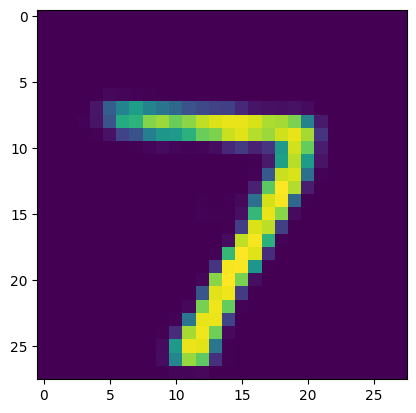

In [20]:
plt.imshow(images[0][1].reshape(28, 28))

(10, 2)


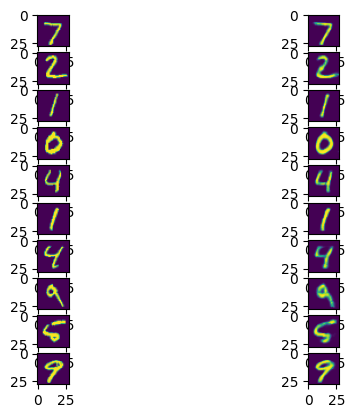

In [21]:
n_images = 10
fig, ax = plt.subplots(nrows=n_images, ncols=2)
print(ax.shape)
indices = np.random.choice(len(images), n_images)
for idx in range(n_images):
    ax[idx][0].imshow(images[idx][0].reshape(28, 28))
    ax[idx][1].imshow(images[idx][1].reshape(28, 28))


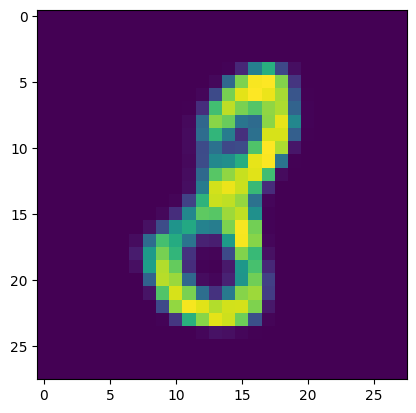

In [22]:
def generate(decoder):
    noise = torch.randn(batch_size, latent_dim)
    generated_images = decoder(noise).cpu().detach()
    return generated_images

generated_images = generate(decoder=decoder)
plt.imshow(generated_images[0].reshape(28, 28))